## Modèle de Heston

Le modèle de Heston est un modèle stochastique à volatilité non constante utilisé pour la modélisation de l'évolution du prix d’un actif. Pour chaque actif i, il est défini par le système d'équations différentielles stochastiques suivant :

\[
\begin{cases}
dS_t^{(i)} = \mu S_t^{(i)}\, dt + \sqrt{v_t^{(i)}}\, S_t^{(i)}\, dB_t^{(i)}   -->  dln(S_t^{(i)}) = (\mu - 0.5.v_t^{(i)})dt + \sqrt{v_t^{(i)}}\, dB_t^{(i)}\\
dv_t^{(i)} = \kappa^{(i)}(\theta^{(i)} - v_t^{(i)})\, dt + \sigma^{(i)} \sqrt{v_t^{(i)}}\, dW_t^{(i)} \\
\end{cases}
\]

avec une corrélation entre les deux mouvements browniens donnée par :

\[
\begin{cases}
dB_t^{(i)} dW_t^{(i)} = \rho^{(i)}\, dt \\
\end{cases}
\]

### Signification des paramètres :

- \( S_t \) : prix de l’actif à l’instant \( t \)
- \( v_t \) : variance instantanée (volatilité au carré)
- \( \mu \) : taux de rendement de l’actif
- \( \kappa \) : vitesse de retour à la moyenne
- \( \theta \) : niveau de variance de long terme
- \( \sigma \) : volatilité de la variance (aussi appelée "vol of vol")
- \( \rho \) : corrélation entre les deux bruits browniens



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
#import warnings
from copy import deepcopy

from scipy.optimize import minimize
import matplotlib.pyplot as plt

from Classes.marketmodel_interface import MarketModel
from Classes.simulation_interface import Simulation

### Import data for calibration
CAC40

In [2]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
Data10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]
# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    Data10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in Data10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

data = histo_CAC40.dropna()
nb_stocks = 40
allocations_EW = np.ones(nb_stocks) / nb_stocks
# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values

In [5]:
Data10y_dic['SCHNEIDERELECTRIC']

,ouv,haut,bas,clot,vol,devise
date,,,,,,
2015-03-09,71.34,71.34,70.83,70.86,1304793,EUR
2015-03-10,70.84,71.00,69.76,70.18,1554765,EUR
2015-03-11,70.69,72.36,70.48,72.35,2241489,EUR
2015-03-12,72.72,72.85,71.72,71.83,1594580,EUR
2015-03-13,72.24,73.51,72.02,73.51,2353288,EUR
...,...,...,...,...,...,...
2025-03-03,233.20,235.75,227.65,229.65,1176017,EUR
2025-03-04,224.30,226.55,213.80,218.80,1944198,EUR
2025-03-05,226.45,229.90,224.25,226.15,1523898,EUR


In [6]:
logreturn_data = np.log(data / data.shift() )
logreturn_data.iloc[0,:] = 0.0

begin_date_data = str(data.index[0])[:10]
end_date_data = str(data.index[-1])[:10]

### Heston model
Simulation

In [7]:
def simulation_heston(V0, Theta, rho, kappa, khi, T, S0, r, nb_steps=252, nb_paths=10000):
    """
    Simulate Heston model paths
    
    Parameters:
    -----------
    V0: float
        Initial variance
    Theta: float
        Long-run average variance
    rho: float
        Correlation between stock and variance processes
    kappa: float
        Mean reversion speed
    khi: float
        Volatility of variance
    T: float
        Time horizon in years
    S0: float
        Initial stock price
    nb_steps: int
        Number of time steps
    nb_paths: int
        Number of simulation paths
    
    Returns:
    --------
    tuple: (stock_paths, variance_paths)
        Arrays containing simulated paths for stock price and variance
    """
    
    dt = T/nb_steps
    
    # Initialize arrays
    stock_paths = np.zeros((nb_paths, nb_steps+1))
    variance_paths = np.zeros((nb_paths, nb_steps+1))
    
    # Set initial values
    stock_paths[:, 0] = S0
    variance_paths[:, 0] = V0
    
    # Generate correlated random numbers
    Z1 = np.random.standard_normal((nb_paths, nb_steps))
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.standard_normal((nb_paths, nb_steps))
    
    # Simulate paths
    for t in range(nb_steps):
        # Ensure variance stays positive
        variance_paths[:, t] = np.maximum(variance_paths[:, t], 0)
        # Update variance
        variance_paths[:, t+1] = variance_paths[:, t] + kappa * (Theta - variance_paths[:, t]) * dt + khi * np.sqrt(variance_paths[:, t] * dt) * Z1[:, t]
        # Update stock price
        stock_paths[:, t+1] = stock_paths[:, t] * np.exp((r - 0.5 * variance_paths[:, t]) * dt + np.sqrt(variance_paths[:, t] * dt) * Z2[:, t])
    
    return stock_paths, variance_paths

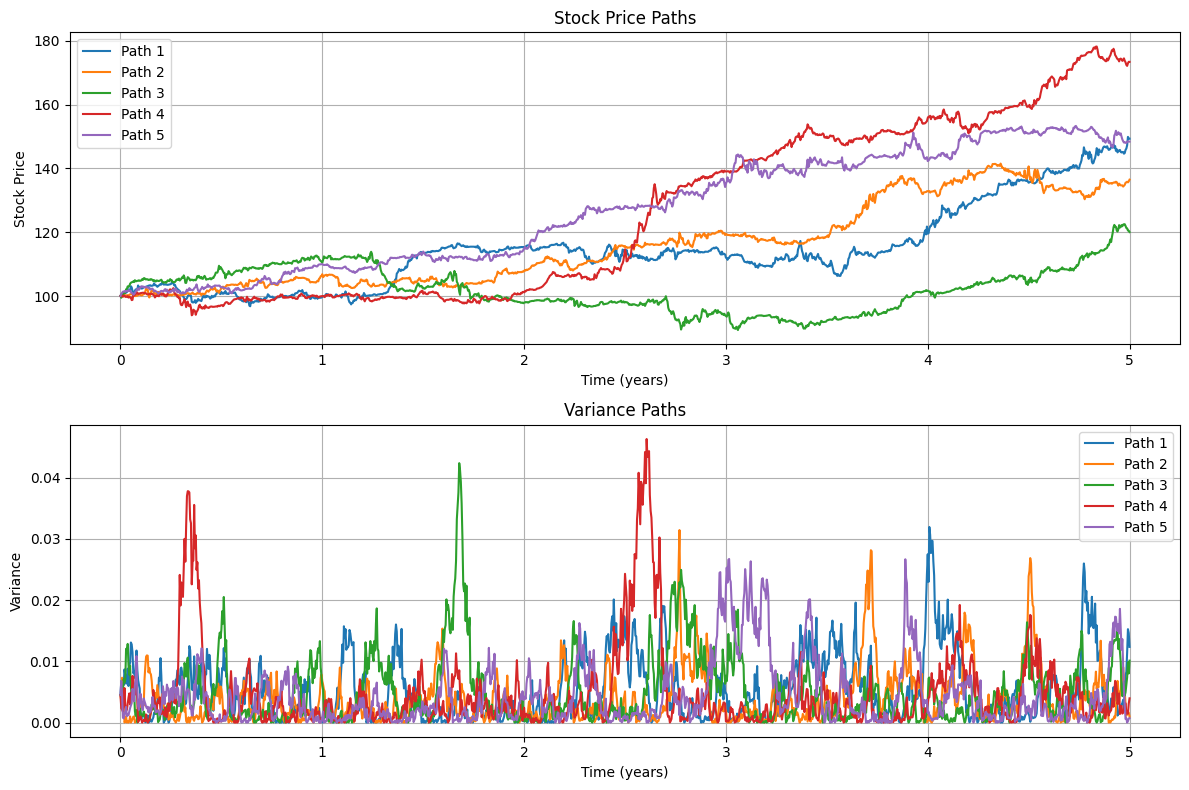

In [206]:
# Simulation parameters
T = 5.0  # 1 year
nb_paths = 5  # number of paths to display
nb_steps = 252*5  # trading days in a year
Stock_price_0 = 100  # initial stock price

# Heston model parameters
V0 = 0.0045 #initial variance
Theta = 0.0041 #the long variance, or long-run average variance of the price
rho = 0.1 #the correlation of the two BROWN processes, the stock price and the variance process
kappa = 14.6431 # the rate at which νt reverts to θ
khi = 40.13/100 #the volatility of the volatility, or 'vol of vol'
mu = 0.07 #the drift of the stock price process

# Run simulation
stock_paths, variance_paths = simulation_heston(V0, Theta, rho, kappa, khi, T, Stock_price_0, mu, nb_steps, nb_paths)

# Create time array
time = np.linspace(0, T, nb_steps + 1)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot stock price paths
for i in range(nb_paths):
    ax1.plot(time, stock_paths[i], label=f'Path {i+1}')
ax1.set_title('Stock Price Paths')
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Stock Price')
ax1.legend()
ax1.grid(True)

# Plot variance paths
for i in range(nb_paths):
    ax2.plot(time, variance_paths[i], label=f'Path {i+1}')
ax2.set_title('Variance Paths')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Variance')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#### Calibration with historical data
1 stock

In [187]:
Data10y_dic.keys()

dict_keys(['ACCOR', 'AIRBUS', 'AIRLIQUIDE', 'ARCELORMITTAL', 'AXA', 'BNPPARIBAS', 'BOUYGUES', 'BUREAUVERITAS', 'CAPGEMINI', 'CARREFOUR', 'CREDITAGRICOLESA', 'DANONE', 'DASSAULTSYSTEMES', 'EDENRED', 'ENGIE', 'ESSILORLUXOTTICA', 'EUROFINSSCIENTIFIC', 'HERMESINTL', 'KERING', 'LEGRAND', 'LOREAL', 'LVMH', 'MICHELIN', 'ORANGE', 'PERNODRICARD', 'PUBLICISGROUPE', 'RENAULT', 'SAFRAN', 'SAINTGOBAIN', 'SANOFI', 'SCHNEIDERELECTRIC', 'SOCIETEGENERALE', 'STELLANTIS', 'STMICROELECTRONICS', 'TELEPERFORMANCE', 'THALES', 'TOTALENERGIES', 'UNIBAILRODAMCOWESTFIELD', 'VEOLIA', 'VINCI'])

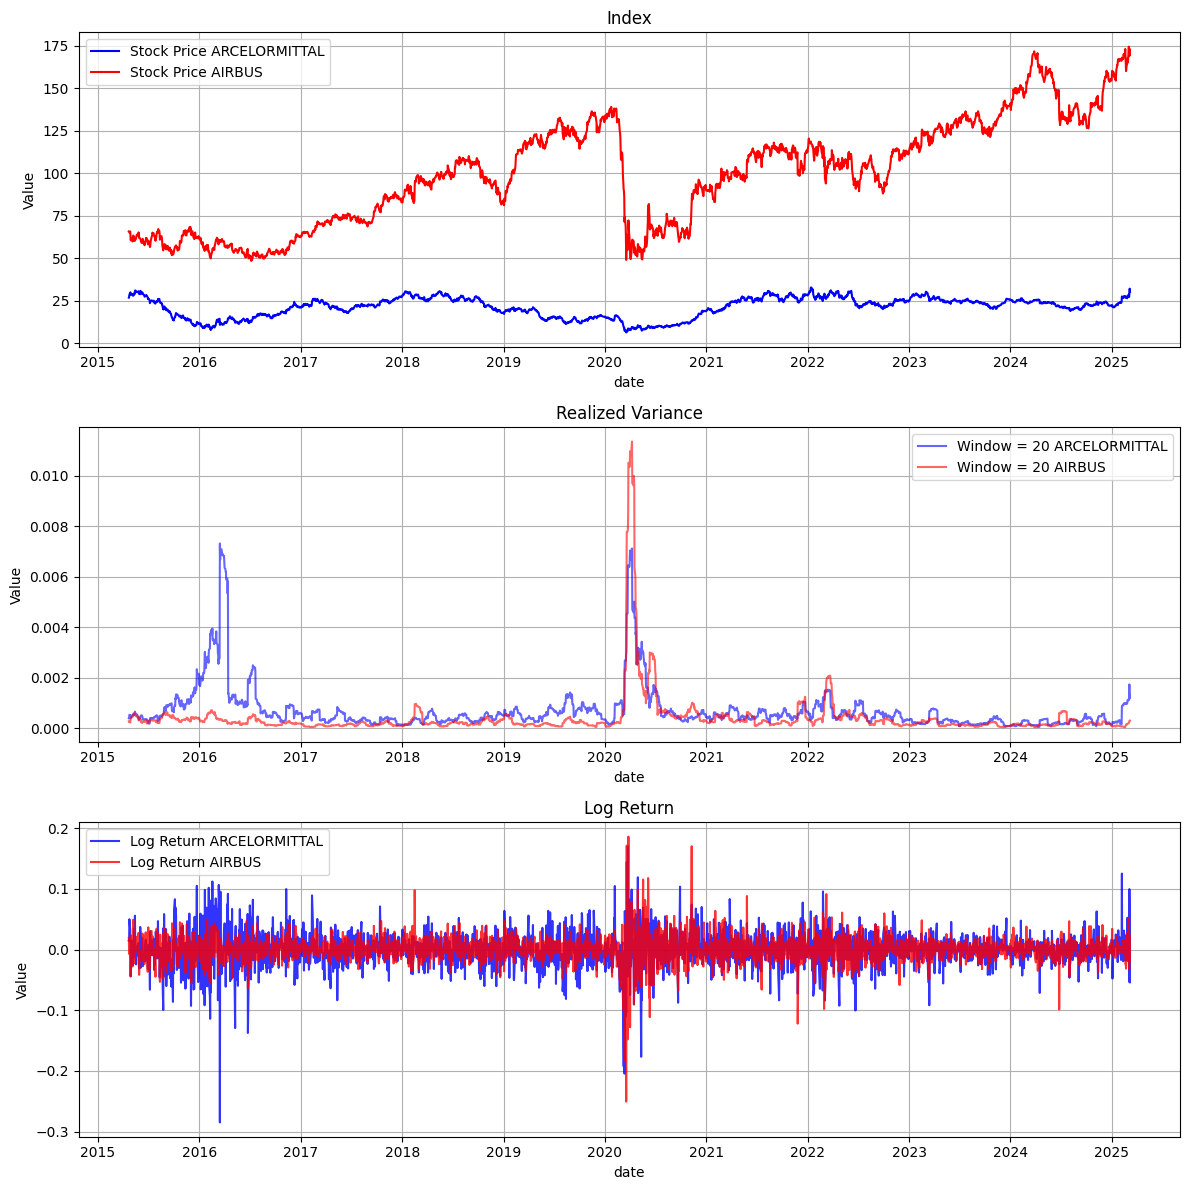

In [ ]:
company1, company2 = 'ARCELORMITTAL', 'AIRBUS'

df = Data10y_dic[company1].copy()
df2 = Data10y_dic[company2].copy()

df.reset_index(inplace=True)
df['LogReturn'] = np.log(df['clot'] / df['clot'].shift(1))
df['Delta days'] = df['date'].diff().dt.total_seconds() / 3600 / 24
df['LogReturn daily'] = df['LogReturn'] / df['Delta days']
df.dropna(inplace=True)

df2.reset_index(inplace=True)
df2['LogReturn'] = np.log(df2['clot'] / df2['clot'].shift(1))
df2['Delta days'] = df2['date'].diff().dt.total_seconds() / 3600 / 24
df2['LogReturn daily'] = df2['LogReturn'] / df2['Delta days']
df2.dropna(inplace=True)

# === 2. Estimer la volatilité instantanée (rolling window) ===
window1 = 10
window2 = 20  # jours
window3 = 30

df['RealizedVar '+str(window1)] = df['LogReturn'].rolling(window1).var()
df['RealizedVar daily ' + str(window1)] = df['LogReturn daily'].rolling(window1).var()
df['RealizedVar '+str(window2)] = df['LogReturn'].rolling(window2).var()
df['RealizedVar daily '+str(window2)] = df['LogReturn daily'].rolling(window2).var()
df['RealizedVar '+str(window3)] = df['LogReturn'].rolling(window3).var()
df['RealizedVar daily '+str(window3)] = df['LogReturn daily'].rolling(window3).var()

df2['RealizedVar '+str(window1)] = df2['LogReturn'].rolling(window1).var()
df2['RealizedVar daily ' + str(window1)] = df2['LogReturn daily'].rolling(window1).var()
df2['RealizedVar '+str(window2)] = df2['LogReturn'].rolling(window2).var()
df2['RealizedVar daily '+str(window2)] = df2['LogReturn daily'].rolling(window2).var()
df2['RealizedVar '+str(window3)] = df2['LogReturn'].rolling(window3).var()
df2['RealizedVar daily '+str(window3)] = df2['LogReturn daily'].rolling(window3).var()

df.dropna(inplace=True)
df2.dropna(inplace=True)

# === Plot index and var on two graph ===
# Create figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
# Plot index value
ax1.plot(df['date'], df['clot'], label='Stock Price '+company1, color='blue')
ax1.plot(df2['date'], df2['clot'], label='Stock Price '+company2, color='red')
ax1.set_title('Index')
ax1.set_xlabel('date')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)
# Plot variance value
#ax2.plot(df['date'], df['RealizedVar daily ' + str(window1)], label='Window = ' +str(window1) + ' ' + company1, color='Blue', alpha=0.8)
#ax2.plot(df['date'], df2['RealizedVar daily ' + str(window1)], label='Window = ' +str(window1) + ' ' + company2, color='Red', alpha=0.8)
ax2.plot(df['date'], df['RealizedVar daily ' + str(window2)], label='Window = ' +str(window2) + ' ' + company1, color='Blue', alpha=0.6)
ax2.plot(df['date'], df2['RealizedVar daily ' + str(window2)], label='Window = ' +str(window2) + ' ' + company2, color='Red', alpha=0.6)
#ax2.plot(df['date'], df['RealizedVar daily ' + str(window3)], label='Window = ' +str(window3) + ' ' + company1, color='blue', alpha=0.4)
#ax2.plot(df['date'], df2['RealizedVar daily ' + str(window3)], label='Window = ' +str(window3) + ' ' + company2, color='red', alpha=0.4)
ax2.set_title('Realized Variance')
ax2.set_xlabel('date')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(True)
# Plot log return
ax3.plot(df['date'], df['LogReturn'], label='Log Return ' + company1, color='blue', alpha=0.8)
ax3.plot(df2['date'], df2['LogReturn'], label='Log Return ' + company2, color='red', alpha=0.8)
ax3.set_title('Log Return')
ax3.set_xlabel('date')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Calibration sur 1 stock

In [260]:
# === 3. Fonction de vraisemblance du modèle de Heston ===
def heston_log_likelihood(params, returns, var, mu):
    kappa, theta, sigma, rho = params
    dt = 1/365.25  # pas de temps (1 jour)
    n = len(returns)
    loglik = 0

    for t in range(1, n):
        v_prev = var[t - 1] * (365.25)**0.5 
        v_curr = var[t] * (365.25)**0.5  # volatilité annuelle

        # Moyennes conditionnelles
        mu_r = mu*dt # drift négligé
        mu_v = v_prev + kappa * (theta - v_prev) * dt

        # Variances conditionnelles
        var_r = v_prev * dt
        var_v = sigma**2 * v_prev * dt
        cov_rv = rho * sigma * v_prev * dt  # covariance entre r_t et v_t

        # Densité gaussienne bivariée (rendement, variance)
        x = np.array([returns[t] - mu_r, v_curr - mu_v])
        cov_matrix = np.array([[var_r, cov_rv],
                               [cov_rv, var_v]])
        
        try:
            det = np.linalg.det(cov_matrix)
            inv = np.linalg.inv(cov_matrix)
            ll = -0.5 * np.log(2 * np.pi)**2 - 0.5 * np.log(det) - 0.5 * x.T @ inv @ x
            loglik += ll
        except np.linalg.LinAlgError:
            return np.inf  # éviter les cas non-inversibles

    return -loglik

# === 4. Calibration par MLE ===
returns = df['LogReturn daily'].values
mu = df['LogReturn'].mean() * 365.25  # annualized mean return
var1 = df['RealizedVar daily ' + str(window1)].values
var2 = df['RealizedVar daily ' + str(window2)].values
var3 = df['RealizedVar daily ' + str(window3)].values

# initial guess
initial_guess = [1.0, 0.02, 0.5, -0.01]  # [kappa, theta, sigma, rho]
bounds = [(0.01, 70.0),  # kappa
          (1e-6, 0.5),   # theta
          (1e-6, 1.5),   # sigma
          (-0.3, 0.3)]  # rho

# Optimisation
res1 = minimize(heston_log_likelihood,
               initial_guess,
               args=(returns, var1, mu),
               bounds=bounds,
               method='L-BFGS-B')
# Affichage des résultats
print("=== Résultats de la calibration ===")
kappa1, theta1, sigma1, rho1 = res1.x
print(f"Paramètres estimés with window=" + str(window1))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa1:.4f}")
print(f"  θ  = {theta1:.4f}")
print(f"  σ  = {sigma1:.4f}")
print(f"  ρ  = {rho1:.4f}")

res2 = minimize(heston_log_likelihood,
               initial_guess,
               args=(returns, var2, mu),
               bounds=bounds,
               method='L-BFGS-B')

# Affichage des résultats
kappa2, theta2, sigma2, rho2 = res2.x
print(f"Paramètres estimés with window=" + str(window2))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa2:.4f}")
print(f"  θ  = {theta2:.4f}")
print(f"  σ  = {sigma2:.4f}")
print(f"  ρ  = {rho2:.4f}")


res3 = minimize(heston_log_likelihood,
               initial_guess,
                args=(returns, var3, mu),
                bounds=bounds,
                method='L-BFGS-B')
# Affichage des résultat
kappa3, theta3, sigma3, rho3 = res3.x
print(f"Paramètres estimés with window=" + str(window3))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa3:.4f}")
print(f"  θ  = {theta3:.4f}")
print(f"  σ  = {sigma3:.4f}")
print(f"  ρ  = {rho3:.4f}")


=== Résultats de la calibration ===
Paramètres estimés with window=10
  μ  = 0.0202
  κ  = 13.8264
  θ  = 0.0136
  σ  = 0.6877
  ρ  = -0.0049
Paramètres estimés with window=20
  μ  = 0.0202
  κ  = 5.3610
  θ  = 0.0136
  σ  = 0.3655
  ρ  = -0.0167
Paramètres estimés with window=30
  μ  = 0.0202
  κ  = 2.4826
  θ  = 0.0143
  σ  = 0.2334
  ρ  = -0.0079


#### Multi Calibration

In [ ]:
logReturn_daily = np.log(data / data.shift(1))
logReturn_daily /= data.index.to_series().diff().dt.days.values.reshape(-1, 1)

#Compute the rolling variance using a window of 20 days for each stock
realized_var = logReturn_daily.rolling(window).var()
realized_var.dropna(inplace=True)

# initial guess
initial_guess = [0.1, 1.0, 0.02, 0.5, -0.01]  # [mu, kappa, theta, sigma, rho]
bounds = [(-0.5, 1.5),  # mu
          (0.01, 20.0),  # kappa
          (1e-6, 0.9),   # theta
          (1e-6, 2),   # sigma
          (-0.3, 0.6)]  # rho

df_params = pd.DataFrame(index=['mu', 'kappa', 'theta', 'sigma', 'rho'], columns=data.columns)
df_params.index.name = 'Parameters'

for company in data.columns:
    returns = logReturn_daily.iloc[window:,:][company].values
    var = realized_var[company].values

    # Optimisation
    res = minimize(heston_log_likelihood,
                   initial_guess,
                   args=(returns, var),
                   bounds=bounds,
                   method='L-BFGS-B')
    
    # Affichage des résultats
    mu, kappa, theta, sigma, rho = res.x
    df_params[company] = [mu, kappa, theta, sigma, rho]

df_params

In [191]:
data.head(5)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-06-05,45.22,98.98,81.382,28.680,21.730,53.12,39.52,20.858,114.80,14.326,...,73.80,33.963,11.028,21.16,136.5,108.70,48.840,192.45,18.686,82.435
2018-06-06,45.04,100.00,82.206,29.485,21.630,53.69,39.82,20.956,114.70,14.103,...,73.94,33.885,11.186,21.46,136.4,108.40,49.233,192.20,18.512,82.474
2018-06-07,44.00,99.65,82.056,28.750,21.800,54.11,39.62,20.868,113.45,14.075,...,74.20,34.127,11.279,21.24,136.7,108.05,49.849,193.70,18.531,82.144
2018-06-08,43.40,100.90,82.056,28.045,21.800,53.70,39.18,21.112,113.20,13.908,...,73.60,33.908,11.219,21.04,137.3,110.35,49.587,192.10,18.406,81.853
2018-06-11,43.75,100.90,83.031,28.600,21.985,54.68,39.36,21.122,113.60,13.968,...,74.24,34.445,11.159,21.35,137.4,109.60,49.871,189.60,18.478,81.989


In [193]:
logReturn_daily = np.log(data / data.shift(1))
logReturn_daily /= data.index.to_series().diff().dt.days.values.reshape(-1, 1)
logReturn_daily.head(10)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-06,-0.003988,0.010252,0.010074,0.027682,-0.004613,0.010673,0.007562,0.004687,-0.000871,-0.015689,...,0.001895,-0.002299,0.014226,0.014078,-0.000733,-0.002764,0.008014,-0.001300,-0.009355,0.000473
2018-06-07,-0.023361,-0.003506,-0.001826,-0.025244,0.007829,0.007792,-0.005035,-0.004208,-0.010958,-0.001987,...,0.003510,0.007116,0.008280,-0.010305,0.002197,-0.003234,0.012434,0.007774,0.001026,-0.004009
2018-06-08,-0.013730,0.012466,0.000000,-0.024827,0.000000,-0.007606,-0.011168,0.011625,-0.002206,-0.011936,...,-0.008119,-0.006438,-0.005334,-0.009461,0.004380,0.021063,-0.005270,-0.008295,-0.006768,-0.003549
2018-06-11,0.002677,0.000000,0.003937,0.006532,0.002817,0.006028,0.001528,0.000158,0.001176,0.001435,...,0.002886,0.005238,-0.001787,0.004875,0.000243,-0.002273,0.001904,-0.004366,0.001301,0.000553
2018-06-12,0.012493,-0.004171,-0.006343,-0.009309,-0.003874,-0.000366,-0.006628,0.007781,0.012683,0.030806,...,-0.001618,0.004750,-0.001973,-0.003284,0.005806,0.000000,-0.008741,-0.010605,0.003943,-0.004511
2018-06-13,0.000000,-0.002990,0.003630,0.016451,-0.006413,-0.002748,-0.010283,0.029303,0.010376,-0.011661,...,0.005650,-0.012561,0.012138,0.043225,0.020767,-0.001370,-0.004806,0.009021,0.001024,-0.000956
2018-06-14,0.008094,0.042793,0.014376,0.008297,0.003441,0.006036,0.004383,0.038396,0.014942,0.013603,...,0.015442,-0.001757,0.029542,0.018725,-0.009256,0.011356,0.015069,0.011555,0.012894,0.021198
2018-06-15,-0.008094,-0.009224,-0.013024,-0.036463,-0.010821,-0.012847,-0.009824,-0.007314,-0.001272,0.003182,...,-0.007958,-0.014645,-0.008997,-0.007982,0.056324,0.000903,-0.009697,0.008320,0.002548,-0.008888


In [194]:
window = 20
#Compute the rolling variance using a window of 20 days for each stock
realized_var = logReturn_daily.rolling(window).var()
realized_var.dropna(inplace=True)
realized_var.head(10)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,0.000106,0.000239,0.000075,0.000294,0.000030,0.000049,0.000063,0.000199,0.000096,0.000131,...,0.000124,0.000042,0.000258,0.000481,0.000197,0.000074,0.000132,0.000051,0.000113,0.000088
2018-07-04,0.000107,0.000236,0.000074,0.000230,0.000032,0.000043,0.000061,0.000208,0.000121,0.000146,...,0.000132,0.000042,0.000247,0.000493,0.000196,0.000074,0.000130,0.000060,0.000111,0.000089
2018-07-05,0.000084,0.000235,0.000089,0.000320,0.000031,0.000055,0.000069,0.000205,0.000125,0.000163,...,0.000132,0.000049,0.000308,0.000541,0.000198,0.000073,0.000132,0.000057,0.000122,0.000096
2018-07-06,0.000082,0.000231,0.000094,0.000307,0.000031,0.000054,0.000068,0.000203,0.000125,0.000157,...,0.000132,0.000047,0.000307,0.000542,0.000199,0.000052,0.000134,0.000055,0.000147,0.000095
2018-07-09,0.000083,0.000231,0.000093,0.000305,0.000031,0.000052,0.000068,0.000202,0.000125,0.000156,...,0.000133,0.000046,0.000307,0.000541,0.000200,0.000052,0.000135,0.000054,0.000147,0.000095
2018-07-10,0.000075,0.000297,0.000095,0.000303,0.000033,0.000056,0.000068,0.000202,0.000119,0.000108,...,0.000134,0.000047,0.000322,0.000568,0.000203,0.000058,0.000134,0.000047,0.000148,0.000094
2018-07-11,0.000075,0.000297,0.000107,0.000337,0.000043,0.000068,0.000079,0.000170,0.000114,0.000221,...,0.000156,0.000048,0.000322,0.000472,0.000190,0.000067,0.000175,0.000059,0.000148,0.000097
2018-07-12,0.000076,0.000228,0.000099,0.000386,0.000041,0.000066,0.000079,0.000100,0.000107,0.000239,...,0.000142,0.000048,0.000276,0.000462,0.000184,0.000081,0.000165,0.000052,0.000151,0.000081
2018-07-13,0.000073,0.000236,0.000089,0.000332,0.000037,0.000058,0.000077,0.000096,0.000107,0.000235,...,0.000145,0.000039,0.000273,0.000467,0.000044,0.000092,0.000159,0.000054,0.000151,0.000079


In [109]:
# initial guess
initial_guess = [0.1, 1.0, 0.02, 0.5, -0.01]  # [mu, kappa, theta, sigma, rho]
bounds = [(-0.5, 1.5),  # mu
          (0.01, 20.0),  # kappa
          (1e-6, 0.9),   # theta
          (1e-6, 2),   # sigma
          (-0.3, 0.6)]  # rho

df_params = pd.DataFrame(index=['mu', 'kappa', 'theta', 'sigma', 'rho'], columns=data.columns)
df_params.index.name = 'Parameters'

for company in data.columns:
    returns = logReturn_daily.iloc[window:,:][company].values
    var = realized_var[company].values

    # Optimisation
    res = minimize(heston_log_likelihood,
                   initial_guess,
                   args=(returns, var),
                   bounds=bounds,
                   method='L-BFGS-B')
    
    # Affichage des résultats
    mu, kappa, theta, sigma, rho = res.x
    df_params[company] = [mu, kappa, theta, sigma, rho]

df_params

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
Parameters,,,,,,,,,,,,,,,,,,,,,
mu,0.029139,0.041513,0.073514,-0.261054,0.057971,0.080130,0.031658,0.144695,0.013232,-0.189482,...,0.191225,0.204508,-0.102140,0.037590,0.102434,0.038950,-0.182085,-0.357213,0.121614,0.124415
kappa,4.007890,3.299728,6.506529,6.923318,4.551051,5.718555,5.510808,5.402290,6.290711,12.589525,...,5.925058,5.156734,6.877845,10.946877,9.889180,6.161074,3.684659,2.446001,3.948495,3.101858
theta,0.006841,0.009127,0.002568,0.012200,0.004142,0.006409,0.004837,0.003398,0.006574,0.004696,...,0.005221,0.009136,0.009159,0.010766,0.009363,0.005028,0.005117,0.014119,0.004645,0.004637
sigma,0.267840,0.312040,0.168573,0.339240,0.250870,0.234363,0.274214,0.190514,0.267999,0.299237,...,0.209434,0.351038,0.348000,0.350028,1.128209,0.218382,0.210824,0.435747,0.204820,0.218714
rho,-0.013738,-0.026757,-0.006845,-0.014727,-0.039916,-0.043914,-0.045248,0.008385,-0.011943,-0.008304,...,-0.016346,-0.003236,-0.032053,-0.046189,-0.103869,-0.014607,-0.037133,-0.037456,-0.035685,-0.030364


In [ ]:
mu = df_params.loc['mu'].values
kappa = df_params.loc['kappa'].values
theta = df_params.loc['theta'].values
sigma = df_params.loc['sigma'].values
rho = df_params.loc['rho'].values

In [ ]:
log_return_considered = logReturn_daily.iloc[window:,:].copy()
dB = log_return_considered - ( mu*np.ones(log_return_considered.shape) * - 0.5 * realized_var) / np.sqrt(realized_var)

(array([0.00079469, 0.        , 0.        , 0.00039735, 0.        ,
        0.00079469, 0.        , 0.        , 0.00039735, 0.        ,
        0.00039735, 0.00039735, 0.00039735, 0.        , 0.00079469,
        0.00039735, 0.00079469, 0.00079469, 0.00119204, 0.00158938,
        0.00119204, 0.00039735, 0.00238408, 0.00158938, 0.00238408,
        0.00158938, 0.00238408, 0.00317877, 0.00317877, 0.00357612,
        0.00437081, 0.0051655 , 0.00476815, 0.00397346, 0.00556285,
        0.00675489, 0.00794692, 0.00635754, 0.00675489, 0.00913896,
        0.00715223, 0.00834427, 0.01311242, 0.01231773, 0.01231773,
        0.01748323, 0.01629119, 0.01708589, 0.01946996, 0.02344343,
        0.02463547, 0.02821158, 0.02940362, 0.02980097, 0.03456912,
        0.02463547, 0.030993  , 0.02225139, 0.020662  , 0.01748323,
        0.01708589, 0.01430446, 0.01986731, 0.01390712, 0.01192039,
        0.00675489, 0.00556285, 0.00913896, 0.00913896, 0.00635754,
        0.00596019, 0.00556285, 0.00596019, 0.00

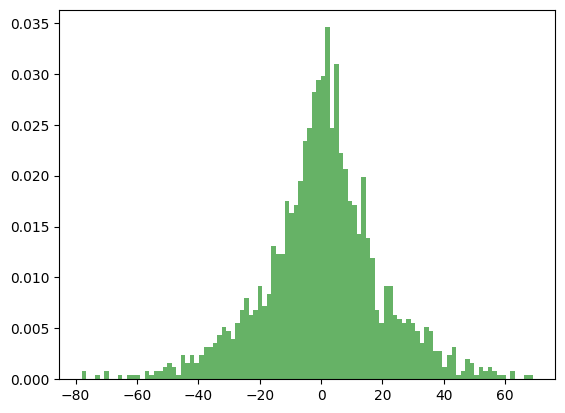

In [256]:
liste = (dB* 365.25**0.5)['AIRBUS'].tolist()
#Histogramme
plt.hist(liste, bins=100, density=True, alpha=0.6, color='g')

In [ ]:
dB.corr()

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
ACCOR,1.000000,0.641569,0.399590,0.507810,0.574927,0.590002,0.537756,0.419050,0.444349,0.238295,...,0.484083,0.581716,0.535532,0.417005,0.227674,0.379652,0.486535,0.500798,0.481072,0.623784
AIRBUS,0.641569,1.000000,0.445913,0.525058,0.563498,0.567351,0.575213,0.436487,0.455926,0.203152,...,0.505532,0.550968,0.547100,0.431927,0.250904,0.520391,0.514115,0.470524,0.495549,0.650177
AIRLIQUIDE,0.399590,0.445913,1.000000,0.434915,0.515864,0.450378,0.487278,0.514281,0.460048,0.310240,...,0.612732,0.416718,0.452682,0.455375,0.268513,0.337650,0.412094,0.348755,0.490415,0.561786
ARCELORMITTAL,0.507810,0.525058,0.434915,1.000000,0.579475,0.609342,0.523365,0.379603,0.429746,0.277356,...,0.528229,0.616076,0.595292,0.520686,0.244592,0.341091,0.574237,0.407098,0.410649,0.521382
AXA,0.574927,0.563498,0.515864,0.579475,1.000000,0.716788,0.599274,0.451215,0.466938,0.320951,...,0.558270,0.699509,0.587848,0.434370,0.242461,0.386153,0.605632,0.464685,0.551002,0.655944
BNPPARIBAS,0.590002,0.567351,0.450378,0.609342,0.716788,1.000000,0.589301,0.439633,0.409493,0.313189,...,0.547071,0.850702,0.610880,0.451262,0.207061,0.312664,0.589654,0.462679,0.524069,0.632430
BOUYGUES,0.537756,0.575213,0.487278,0.523365,0.599274,0.589301,1.000000,0.432321,0.404274,0.323408,...,0.504219,0.585257,0.569744,0.410150,0.246161,0.404877,0.516240,0.447810,0.501265,0.690363
BUREAUVERITAS,0.419050,0.436487,0.514281,0.379603,0.451215,0.439633,0.432321,1.000000,0.453436,0.210297,...,0.508062,0.402155,0.422199,0.406530,0.330200,0.322986,0.344235,0.352547,0.454915,0.476724
CAPGEMINI,0.444349,0.455926,0.460048,0.429746,0.466938,0.409493,0.404274,0.453436,1.000000,0.121929,...,0.527958,0.384815,0.452464,0.526533,0.305171,0.272771,0.343572,0.352346,0.460885,0.469769
CARREFOUR,0.238295,0.203152,0.310240,0.277356,0.320951,0.313189,0.323408,0.210297,0.121929,1.000000,...,0.230417,0.320432,0.286694,0.141985,0.112907,0.177543,0.280781,0.194049,0.247588,0.317444


In [161]:
dVt = realized_var - realized_var.shift(1)
dVt.dropna(inplace=True)
dVt.head(5)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-04,3.981196e-07,-3.679260e-06,-1.363395e-06,-0.000064,1.985569e-06,-0.000006,-1.130536e-06,8.488467e-06,2.447800e-05,1.557233e-05,...,7.492701e-06,4.850033e-07,-1.141292e-05,0.000013,-7.800396e-07,-3.732391e-07,-1.880282e-06,0.000009,-2.577327e-06,1.261936e-06
2018-07-05,-2.276227e-05,-4.273560e-07,1.449891e-05,0.000090,-1.755700e-06,0.000012,7.473637e-06,-2.626672e-06,4.386148e-06,1.690268e-05,...,5.544351e-07,6.515508e-06,6.092412e-05,0.000048,2.751607e-06,-1.078548e-06,2.303218e-06,-0.000003,1.121686e-05,6.664802e-06
2018-07-06,-2.428603e-06,-4.225868e-06,4.998392e-06,-0.000013,3.054215e-08,-0.000002,-7.284590e-07,-2.357299e-06,-3.350258e-07,-6.858075e-06,...,-5.597336e-07,-1.651185e-06,-5.532979e-07,0.000001,9.753941e-07,-2.024905e-05,1.935100e-06,-0.000002,2.476531e-05,-1.050224e-06
2018-07-09,1.409669e-06,-1.358957e-08,-6.108819e-07,-0.000002,-1.201100e-07,-0.000002,-2.209609e-07,-2.826678e-07,6.217236e-09,-4.151646e-08,...,1.211955e-06,-1.534820e-06,-4.467726e-09,-0.000002,7.458841e-07,-2.606712e-07,4.628167e-07,-0.000001,6.342939e-07,-3.468819e-08
2018-07-10,-8.378973e-06,6.633339e-05,2.114746e-06,-0.000002,2.586474e-06,0.000005,1.343894e-07,-8.209725e-07,-5.168844e-06,-4.887939e-05,...,7.211117e-07,9.973890e-07,1.433874e-05,0.000027,2.845653e-06,5.553367e-06,-1.007078e-06,-0.000007,4.597050e-07,-8.845685e-07


In [165]:
theta / 365.25**0.5 - realized_var.iloc[:-1,:]

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,0.000251,0.000238,0.000059,0.000344,0.000186,0.000287,0.000191,-0.000021,0.000248,0.000115,...,0.000149,0.000436,0.000221,0.000082,0.000293,0.000189,0.000136,0.000687,0.000130,0.000155
2018-07-04,0.000251,0.000242,0.000060,0.000408,0.000184,0.000292,0.000192,-0.000030,0.000223,0.000099,...,0.000141,0.000436,0.000232,0.000070,0.000294,0.000189,0.000138,0.000679,0.000132,0.000154
2018-07-05,0.000274,0.000242,0.000046,0.000318,0.000186,0.000280,0.000184,-0.000027,0.000219,0.000082,...,0.000141,0.000429,0.000171,0.000022,0.000291,0.000190,0.000136,0.000681,0.000121,0.000147
2018-07-06,0.000276,0.000247,0.000041,0.000331,0.000186,0.000282,0.000185,-0.000025,0.000219,0.000089,...,0.000141,0.000431,0.000172,0.000021,0.000290,0.000211,0.000134,0.000684,0.000096,0.000148
2018-07-09,0.000275,0.000247,0.000041,0.000333,0.000186,0.000283,0.000185,-0.000025,0.000219,0.000089,...,0.000140,0.000432,0.000172,0.000023,0.000290,0.000211,0.000133,0.000685,0.000096,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.000187,0.000298,0.000039,-0.000465,0.000118,0.000156,0.000211,-0.000007,-0.000476,-0.000235,...,-0.000140,-0.000421,0.000058,-0.000197,-0.000201,0.000105,0.000209,0.000559,0.000128,0.000155
2025-03-03,0.000186,0.000281,0.000040,-0.000460,0.000117,0.000165,0.000211,-0.000004,-0.000477,-0.000234,...,-0.000135,-0.000403,0.000069,-0.000185,-0.000211,0.000014,0.000210,0.000561,0.000128,0.000156
2025-03-04,0.000123,0.000229,0.000031,-0.000634,0.000133,0.000166,0.000212,-0.000002,-0.000472,-0.000240,...,-0.000254,-0.000492,-0.000474,-0.000594,-0.000227,0.000003,0.000186,0.000566,0.000135,0.000162


In [251]:
dVt = realized_var - realized_var.shift(1)
dVt.dropna(inplace=True)
dW = (dVt - kappa/365.25*(theta/365.25**0.5 - realized_var.iloc[:-1,:]) ) * 1/np.sqrt(realized_var.iloc[:-1,:]) / sigma
dW.dropna(inplace=True)
dW.tail(5)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2025-02-28,-0.002570,-0.003069,0.000633,0.001346,-0.000537,-0.002303,-0.004750,0.004373,0.001622,0.000454,...,-0.001641,0.002812,0.000181,0.001997,0.011636,0.002791,-0.005175,-0.003446,-0.000922,-0.003179
2025-03-03,-0.001888,0.001442,-0.001526,0.001247,-0.001649,-0.005254,-0.004961,-0.000954,0.002553,0.001296,...,0.000334,-0.000139,-0.001970,-0.000514,0.000603,0.026231,-0.005844,-0.004070,-0.002522,-0.003490
2025-03-04,0.014139,0.008609,0.004685,0.016472,-0.008897,-0.002377,-0.005602,-0.000764,0.001875,0.002247,...,0.026756,0.009916,0.052340,0.036338,0.000838,0.002952,0.008793,-0.004870,-0.005894,-0.006631
2025-03-05,0.004091,0.004517,0.003596,0.035487,-0.000719,0.015661,0.020521,-0.003199,0.024135,0.002012,...,0.006687,0.007891,0.013963,0.010476,0.004558,0.042945,-0.011551,0.001556,0.006011,0.034810
2025-03-06,-0.003454,-0.002008,-0.004483,-0.046665,-0.003560,0.002878,0.024381,-0.000728,0.017449,0.007165,...,-0.006855,-0.088011,0.003980,0.008254,0.006745,-0.016065,-0.007430,0.007566,-0.001070,-0.002614


(array([0.02551916, 0.01275958, 0.01275958, 0.        , 0.        ,
        0.        , 0.        , 0.01275958, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.02551916, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01275958,
        0.        , 0.02551916, 0.        , 0.02551916, 0.        ,
        0.        , 0.        , 0.02551916, 0.01275958, 0.01275958,
        0.02551916, 0.03827875, 0.05103833, 0.11483624, 0.06379791,
        0.19139373, 0.06379791, 0.14035541, 0.17863415, 0.4338258 ,
        0.56142162, 0.6507387 , 1.35251572, 6.17563784, 6.94121278,
        1.78634152, 0.80385369, 0.54866204, 0.42106622, 0.29347039,
        0.20415332, 0.19139373, 0.06379791, 0.05103833, 0.03827875,
        0.05103833, 0.        , 0.02551916, 0.        , 0.03827875,
        0.        , 0.        , 0.01275958, 0.02

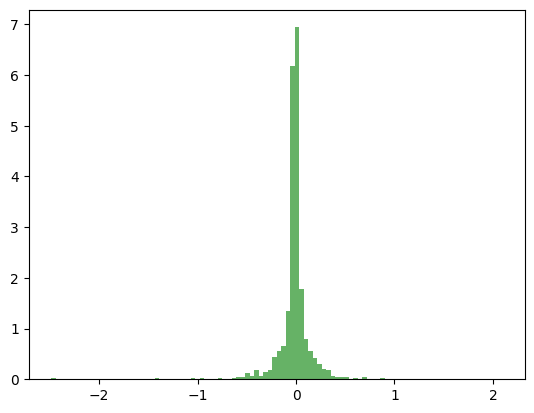

In [183]:
liste = (dW* 365.25**0.5)['AIRBUS'].tolist()
#Histogramme
plt.hist(liste, bins=100, density=True, alpha=0.6, color='g')

In [185]:
dW.corr()

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
ACCOR,1.000000,0.419842,0.277301,0.282875,0.354012,0.341941,0.268738,0.291637,0.211607,0.104811,...,0.400567,0.378739,0.284193,0.189223,0.045538,0.274308,0.359113,0.318492,0.401952,0.461897
AIRBUS,0.419842,1.000000,0.252293,0.341661,0.351207,0.382340,0.306269,0.266372,0.266620,0.102427,...,0.332889,0.382852,0.307291,0.233715,0.049915,0.385363,0.434661,0.335372,0.358674,0.509884
AIRLIQUIDE,0.277301,0.252293,1.000000,0.300158,0.330244,0.283020,0.228968,0.257146,0.246119,0.149476,...,0.413006,0.267848,0.255830,0.284897,0.104439,0.173520,0.305876,0.220708,0.421437,0.380852
ARCELORMITTAL,0.282875,0.341661,0.300158,1.000000,0.409223,0.403996,0.277652,0.171107,0.269235,0.122104,...,0.392938,0.466676,0.340888,0.267932,0.057837,0.272795,0.468263,0.237596,0.360300,0.409020
AXA,0.354012,0.351207,0.330244,0.409223,1.000000,0.444149,0.317759,0.274426,0.307617,0.127137,...,0.445218,0.456512,0.348520,0.271447,0.073085,0.265884,0.496689,0.338385,0.504178,0.477319
BNPPARIBAS,0.341941,0.382340,0.283020,0.403996,0.444149,1.000000,0.215702,0.177074,0.234866,0.100349,...,0.385865,0.658979,0.313215,0.244282,0.064176,0.224611,0.436709,0.352371,0.392438,0.457539
BOUYGUES,0.268738,0.306269,0.228968,0.277652,0.317759,0.215702,1.000000,0.145488,0.207146,0.134479,...,0.277453,0.243156,0.265392,0.162780,0.046480,0.220595,0.329315,0.250458,0.326590,0.416059
BUREAUVERITAS,0.291637,0.266372,0.257146,0.171107,0.274426,0.177074,0.145488,1.000000,0.237867,0.117010,...,0.269598,0.197078,0.174898,0.207540,0.124854,0.169798,0.181958,0.222508,0.299492,0.266226
CAPGEMINI,0.211607,0.266620,0.246119,0.269235,0.307617,0.234866,0.207146,0.237867,1.000000,0.147101,...,0.345239,0.243252,0.226078,0.280523,0.159848,0.211246,0.280787,0.262980,0.284752,0.302480
CARREFOUR,0.104811,0.102427,0.149476,0.122104,0.127137,0.100349,0.134479,0.117010,0.147101,1.000000,...,0.163513,0.114764,0.117966,0.130259,0.064752,0.103969,0.152844,0.122065,0.196662,0.222350


In [249]:
# ajouter "S_" devant le nom de chaque colonne de dB
dB.columns = ['S_' + col for col in dB.columns]
# ajouter "V_" devant le nom de chaque colonne de dW
dW.columns = ['V_' + col for col in dW.columns]
# Concaténer les deux DataFrames
dB_dW = pd.concat([dB, dW], axis=1)
dB_dW.dropna(inplace=True)
dB_dW


,S_S_S_ACCOR,S_S_S_AIRBUS,S_S_S_AIRLIQUIDE,S_S_S_ARCELORMITTAL,S_S_S_AXA,S_S_S_BNPPARIBAS,S_S_S_BOUYGUES,S_S_S_BUREAUVERITAS,S_S_S_CAPGEMINI,S_S_S_CARREFOUR,...,V_V_V_SCHNEIDERELECTRIC,V_V_V_SOCIETEGENERALE,V_V_V_STELLANTIS,V_V_V_STMICROELECTRONICS,V_V_V_TELEPERFORMANCE,V_V_V_THALES,V_V_V_TOTALENERGIES,V_V_V_UNIBAILRODAMCOWESTFIELD,V_V_V_VEOLIA,V_V_V_VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-04,-0.005500,0.002771,-0.009046,-0.011006,0.005894,0.000638,0.006579,-0.007619,-0.021634,0.018586,...,0.002162,-0.002478,-0.002886,0.001341,-0.000554,-0.001903,-0.001361,0.001210,-0.001859,-0.000021
2018-07-05,0.003434,-0.002338,0.016667,0.036464,0.005857,0.017625,0.010002,0.001036,0.014303,0.015960,...,-0.000717,0.000186,0.009448,0.005799,-0.000323,-0.002305,0.000386,-0.002159,0.004380,0.002532
2018-07-06,0.010667,0.008061,0.010472,0.006985,0.000397,-0.004892,0.007536,0.008850,0.002279,0.002663,...,-0.001186,-0.003203,-0.000621,0.000054,-0.000432,-0.015058,0.000241,-0.002167,0.009561,-0.001084
2018-07-09,0.005981,0.003347,0.000810,0.001690,0.002675,0.000598,0.000657,0.002031,0.001393,-0.001185,...,-0.000439,-0.003217,-0.000531,-0.000271,-0.000445,-0.002422,-0.000360,-0.001840,-0.000161,-0.000607
2018-07-10,0.001041,0.039230,0.010818,-0.005966,-0.008561,-0.009017,0.005379,0.005738,0.007504,-0.008987,...,-0.000636,-0.002121,0.001822,0.003289,-0.000306,0.001259,-0.000968,-0.003759,-0.000229,-0.001015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,-0.000434,0.003663,0.012205,-0.004700,-0.006898,0.003974,-0.000200,-0.015456,-0.009153,-0.001297,...,-0.002424,0.001773,0.000353,0.001790,0.011547,0.003676,-0.001288,-0.000245,0.000774,-0.000791
2025-03-03,0.004053,0.017310,0.006083,0.011798,0.006551,0.005788,0.001913,0.002812,-0.001940,-0.008781,...,-0.000430,-0.001144,-0.001762,-0.000709,0.000511,0.026324,-0.001909,-0.000851,-0.000817,-0.001076
2025-03-04,-0.037288,-0.032551,-0.009806,-0.057779,-0.004727,-0.031463,0.008793,-0.003849,-0.033782,0.007429,...,0.025495,0.008747,0.051401,0.035833,0.000740,0.002973,0.011715,-0.001573,-0.004036,-0.004017


In [250]:
dB_dW.corr()

,S_S_S_ACCOR,S_S_S_AIRBUS,S_S_S_AIRLIQUIDE,S_S_S_ARCELORMITTAL,S_S_S_AXA,S_S_S_BNPPARIBAS,S_S_S_BOUYGUES,S_S_S_BUREAUVERITAS,S_S_S_CAPGEMINI,S_S_S_CARREFOUR,...,V_V_V_SCHNEIDERELECTRIC,V_V_V_SOCIETEGENERALE,V_V_V_STELLANTIS,V_V_V_STMICROELECTRONICS,V_V_V_TELEPERFORMANCE,V_V_V_THALES,V_V_V_TOTALENERGIES,V_V_V_UNIBAILRODAMCOWESTFIELD,V_V_V_VEOLIA,V_V_V_VINCI
S_S_S_ACCOR,1.000000,0.641582,0.399520,0.508080,0.575053,0.589947,0.537707,0.418907,0.444259,0.238132,...,-0.059598,-0.032835,-0.034065,-0.051212,-0.013708,-0.000209,-0.072839,0.012463,-0.028849,-0.055957
S_S_S_AIRBUS,0.641582,1.000000,0.445971,0.524720,0.563754,0.567296,0.574930,0.436881,0.455551,0.203107,...,-0.099582,-0.100539,-0.073021,-0.075080,-0.024520,-0.017158,-0.130962,0.006166,-0.091882,-0.131517
S_S_S_AIRLIQUIDE,0.399520,0.445971,1.000000,0.435456,0.515874,0.450348,0.487602,0.514303,0.460175,0.310176,...,-0.060404,-0.067425,-0.048250,-0.048510,-0.005288,-0.004133,-0.079241,-0.004445,-0.085843,-0.065281
S_S_S_ARCELORMITTAL,0.508080,0.524720,0.435456,1.000000,0.580618,0.609761,0.522270,0.380747,0.428930,0.277593,...,-0.096732,-0.064833,-0.034302,-0.023225,-0.022533,0.010810,-0.068364,-0.019634,-0.090443,-0.104040
S_S_S_AXA,0.575053,0.563754,0.515874,0.580618,1.000000,0.716873,0.600090,0.451270,0.467284,0.320956,...,-0.028689,-0.060304,-0.056567,0.012270,0.007540,-0.029469,-0.053974,-0.020705,-0.101824,-0.110306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V_V_V_THALES,-0.000209,-0.017158,-0.004133,0.010810,-0.029469,-0.022191,-0.019873,-0.006199,0.027812,-0.021205,...,0.194922,0.256318,0.221934,0.171771,0.053217,1.000000,0.310317,0.255617,0.239581,0.328251
V_V_V_TOTALENERGIES,-0.072839,-0.130962,-0.079241,-0.068364,-0.053974,-0.087208,-0.105716,-0.082416,-0.034951,-0.045082,...,0.409934,0.441526,0.334054,0.264585,0.059257,0.310317,1.000000,0.300272,0.385741,0.510571
V_V_V_UNIBAILRODAMCOWESTFIELD,0.012463,0.006166,-0.004445,-0.019634,-0.020705,-0.013577,-0.035164,-0.027285,-0.020642,-0.051416,...,0.249781,0.314204,0.262845,0.235420,0.129469,0.255617,0.300272,1.000000,0.369347,0.396891
V_V_V_VEOLIA,-0.028849,-0.091882,-0.085843,-0.090443,-0.101824,-0.099599,-0.144747,-0.032869,-0.069194,-0.079683,...,0.450199,0.443948,0.330599,0.246052,0.088575,0.239581,0.385741,0.369347,1.000000,0.576158


### Code utilisable

##### Calibration de mu, kappa, theta, sigma et rho. à partir du'un data frame de stock histo

In [239]:
def heston_log_likelihood(params : list, returns, var, mu : float):
    kappa, theta, sigma, rho = params
    dt = 1/365.25  # pas de temps (1 jour)
    n = len(returns)
    loglik = 0

    for t in range(1, n):
        v_prev = var[t - 1] * (365.25)**0.5 
        v_curr = var[t] * (365.25)**0.5  # volatilité annuelle

        # Moyennes conditionnelles
        mu_r = mu*dt
        mu_v = v_prev + kappa * (theta - v_prev) * dt

        # Variances conditionnelles
        var_r = v_prev * dt
        var_v = sigma**2 * v_prev * dt
        cov_rv = rho * sigma * v_prev * dt  # covariance entre r_t et v_t

        # Densité gaussienne bivariée (rendement, variance)
        x = np.array([returns[t] - mu_r, v_curr - mu_v])
        cov_matrix = np.array([[var_r, cov_rv],
                               [cov_rv, var_v]])
        
        try:
            det = np.linalg.det(cov_matrix)
            inv = np.linalg.inv(cov_matrix)
            ll = -0.5 * np.log(2 * np.pi)**2 - 0.5 * np.log(det) - 0.5 * x.T @ inv @ x
            loglik += ll
        except np.linalg.LinAlgError:
            return np.inf  # éviter les cas non-inversibles

    return -loglik

In [ ]:
def calibrate_heston_model(data : pd.DataFrame, window : int = 20, 
                           initial_guess : list = [1.0, 0.02, 0.5, -0.01], 
                           bounds : list = [(0.01, 20.0), (1e-6, 0.9), (1e-6, 2), (-0.3, 0.6)]) -> pd.DataFrame:
    """
    Calibrate the Heston model parameters for each stock in the data DataFrame.
    
    Parameters:
    -----------
    data: pd.DataFrame
        DataFrame containing the log returns of the stocks.
    window: int
        Rolling window size for variance calculation.
    initial_guess: list
        Initial guess for the Heston model parameters.
    bounds: list
        Bounds for the Heston model parameters.
    
    Returns:
    --------
    pd.DataFrame: DataFrame containing the calibrated parameters for each stock (mu, kappa, theta, sigma, rho).
    """
    # Compute the log returns daily
    log_return_daily = np.log(data / data.shift(1)) / (data.index.to_series().diff().dt.total_seconds().values.reshape(-1, 1)) *3600*24
    log_return_daily.dropna(inplace=True)
    
    #Compute the rolling variance using a window of window days for each stock
    realized_var = log_return_daily.rolling(window).var()
    realized_var.dropna(inplace=True)
    
    df_params = pd.DataFrame(index=['mu', 'kappa', 'theta', 'sigma', 'rho'], columns=data.columns)
    df_params.index.name = 'Parameters'
    for company in data.columns:
        returns = log_return_daily.iloc[window:, :][company].values
        mu = log_return_daily[company].mean() * 365.25
        var = realized_var[company].values

        # Optimisation
        res = minimize(heston_log_likelihood,
                       initial_guess,
                       args=(returns, var, mu),
                       bounds=bounds,
                       method='L-BFGS-B')
        
        # Affichage des résultats
        kappa, theta, sigma, rho = res.x
        df_params[company] = [mu, kappa, theta, sigma, rho]

    
    log_return_considered = log_return_daily.iloc[window:,:].copy()
    dB = log_return_considered - ( mu*np.ones(log_return_considered.shape) * - 0.5 * realized_var) / np.sqrt(realized_var)
    
    # Compute correlation matrix B. correlation between the different stocks
    dB = log_return_daily.iloc[window:, :] - ( mu*np.ones(log_return_daily.iloc[window:, :].shape) * - 0.5 * realized_var.iloc[:-1,:]) / np.sqrt(realized_var.iloc[:-1,:])
    dB.dropna(inplace=True)
    correlation_matrix_B = dB.corr()

    # Compute the correlation matrix W. correlation between the different variances
    dVt = realized_var - realized_var.shift(1)
    dVt.dropna(inplace=True)
    dVt = dVt.iloc[window:, :]
    dVt = dVt / np.sqrt(realized_var.iloc[:-1,:])
    dVt.dropna(inplace=True)

    # Compute the correlation matrix W. correlation between the different variances
    dVt = realized_var - realized_var.shift(1)
    dVt.dropna(inplace=True)
    dW = (dVt - kappa/365.25*(theta/365.25**0.5 - realized_var.iloc[:-1,:]) ) * 1/np.sqrt(realized_var.iloc[:-1,:]) / sigma
    dW.dropna(inplace=True)
    correlation_matrix_W = dW.corr()
    
    return df_params, correlation_matrix_B, correlation_matrix_W

In [243]:
calibrate_heston_model(data)

           ACCOR AIRBUS AIRLIQUIDE ARCELORMITTAL  AXA BNPPARIBAS BOUYGUES  \
Parameters                                                                  
mu           NaN    NaN        NaN           NaN  NaN        NaN      NaN   
kappa        NaN    NaN        NaN           NaN  NaN        NaN      NaN   
theta        NaN    NaN        NaN           NaN  NaN        NaN      NaN   
sigma        NaN    NaN        NaN           NaN  NaN        NaN      NaN   
rho          NaN    NaN        NaN           NaN  NaN        NaN      NaN   

           BUREAUVERITAS CAPGEMINI CARREFOUR  ... SCHNEIDERELECTRIC  \
Parameters                                    ...                     
mu                   NaN       NaN       NaN  ...               NaN   
kappa                NaN       NaN       NaN  ...               NaN   
theta                NaN       NaN       NaN  ...               NaN   
sigma                NaN       NaN       NaN  ...               NaN   
rho                  NaN       NaN

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
Parameters,,,,,,,,,,,,,,,,,,,,,
mu,0.058937,0.119840,0.168017,-0.017192,0.111275,0.083902,0.009019,0.100909,0.145524,-0.045390,...,0.263977,0.089940,0.048731,0.089254,-0.006468,0.055725,-0.015123,-0.158060,0.132041,0.101476
kappa,4.056282,3.428400,6.536929,7.406379,4.790943,5.727486,5.511201,5.482805,6.325839,12.861513,...,6.046481,5.073986,7.421794,11.264080,2.595625,6.380857,4.166929,2.867826,4.001910,3.040287
theta,0.006795,0.008926,0.002554,0.011858,0.004008,0.006404,0.004808,0.003378,0.006495,0.004660,...,0.005171,0.009190,0.008868,0.010644,0.025886,0.004903,0.004787,0.012782,0.004613,0.004692
sigma,0.268346,0.314792,0.168679,0.339945,0.256132,0.240020,0.281662,0.190639,0.268281,0.299567,...,0.210134,0.351047,0.352430,0.359413,1.330201,0.218282,0.214178,0.443342,0.207769,0.221098
rho,0.007395,0.004420,-0.004170,0.005834,-0.002591,-0.000026,0.002091,-0.006267,-0.009174,0.003250,...,-0.001114,0.005308,0.005945,-0.000841,0.014842,0.002918,-0.002660,0.007213,-0.001729,0.004948


In [227]:
# === 3. Fonction de vraisemblance du modèle de Heston ===
def heston_log_likelihood(params, returns, var, mu):
    kappa, theta, sigma, rho = params
    dt = 1/365.25  # pas de temps (1 jour)
    n = len(returns)
    loglik = 0

    for t in range(1, n):
        v_prev = var[t - 1] * (365.25)**0.5 
        v_curr = var[t] * (365.25)**0.5  # volatilité annuelle

        # Moyennes conditionnelles
        mu_r = mu*dt # drift négligé
        mu_v = v_prev + kappa * (theta - v_prev) * dt

        # Variances conditionnelles
        var_r = v_prev * dt
        var_v = sigma**2 * v_prev * dt
        cov_rv = rho * sigma * v_prev * dt  # covariance entre r_t et v_t

        # Densité gaussienne bivariée (rendement, variance)
        x = np.array([returns[t] - mu_r, v_curr - mu_v])
        cov_matrix = np.array([[var_r, cov_rv],
                               [cov_rv, var_v]])
        
        try:
            det = np.linalg.det(cov_matrix)
            inv = np.linalg.inv(cov_matrix)
            ll = -0.5 * np.log(2 * np.pi)**2 - 0.5 * np.log(det) - 0.5 * x.T @ inv @ x
            loglik += ll
        except np.linalg.LinAlgError:
            return np.inf  # éviter les cas non-inversibles

    return -loglik

# === 4. Calibration par MLE ===
returns = df['LogReturn daily'].values
mu = df['LogReturn'].mean() * 365.25  # annualized mean return
var1 = df['RealizedVar daily ' + str(window1)].values
var2 = df['RealizedVar daily ' + str(window2)].values
var3 = df['RealizedVar daily ' + str(window3)].values

# initial guess
initial_guess = [1.0, 0.02, 0.5, -0.01]  # [kappa, theta, sigma, rho]
bounds = [(0.01, 70.0),  # kappa
          (1e-6, 0.5),   # theta
          (1e-6, 1.5),   # sigma
          (-0.3, 0.3)]  # rho

# Optimisation
res1 = minimize(heston_log_likelihood,
               initial_guess,
               args=(returns, var1, mu),
               bounds=bounds,
               method='L-BFGS-B')
# Affichage des résultats
print("=== Résultats de la calibration ===")
kappa1, theta1, sigma1, rho1 = res1.x
print(f"Paramètres estimés with window=" + str(window1))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa1:.4f}")
print(f"  θ  = {theta1:.4f}")
print(f"  σ  = {sigma1:.4f}")
print(f"  ρ  = {rho1:.4f}")

res2 = minimize(heston_log_likelihood,
               initial_guess,
               args=(returns, var2, mu),
               bounds=bounds,
               method='L-BFGS-B')

# Affichage des résultats
kappa2, theta2, sigma2, rho2 = res2.x
print(f"Paramètres estimés with window=" + str(window2))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa2:.4f}")
print(f"  θ  = {theta2:.4f}")
print(f"  σ  = {sigma2:.4f}")
print(f"  ρ  = {rho2:.4f}")


res3 = minimize(heston_log_likelihood,
               initial_guess,
                args=(returns, var3, mu),
                bounds=bounds,
                method='L-BFGS-B')
# Affichage des résultat
kappa3, theta3, sigma3, rho3 = res3.x
print(f"Paramètres estimés with window=" + str(window3))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa3:.4f}")
print(f"  θ  = {theta3:.4f}")
print(f"  σ  = {sigma3:.4f}")
print(f"  ρ  = {rho3:.4f}")

=== Résultats de la calibration ===
Paramètres estimés with window=10
  μ  = 0.0202
  κ  = 13.8264
  θ  = 0.0136
  σ  = 0.6877
  ρ  = -0.0049
Paramètres estimés with window=20
  μ  = 0.0202
  κ  = 5.3610
  θ  = 0.0136
  σ  = 0.3655
  ρ  = -0.0167
Paramètres estimés with window=30
  μ  = 0.0202
  κ  = 2.4826
  θ  = 0.0143
  σ  = 0.2334
  ρ  = -0.0079
